# Лаборатореая работа №1 по предмету «Машинное Обучени»
**Выполнил: Жаворонков Никита Дмитриевич**

### Подключение билиотек и загрузка данных

In [173]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Разведочный анализ данных (EDA)

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def do_eda(df, target_col='RiskScore', top_k=12, sample_size=10_000):
    """
    Расширенный EDA: не просто корреляции, а визуализация формы зависимости между признаками и target.
    Цель: понять — линейно ли влияет признак? Есть ли пороги? Насыщение? Выбросы?
    """
    print("="*60)
    print(f"📊 EDA для целевой переменной: {target_col}")
    print("="*60)
    
    # 1. Основная статистика и распределение
    print(df[target_col].describe())
    plt.figure(figsize=(8, 4))
    sns.histplot(df[target_col], kde=True, color='royalblue', bins=50)
    plt.title(f'Распределение {target_col}', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # 2. Корреляционная матрица
    numeric_df = df.select_dtypes(include=np.number)
    corr = numeric_df.corr()
    
    plt.figure(figsize=(20, 16))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='vlag', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": .5})
    plt.title('Матрица корреляций', fontsize=16)
    plt.tight_layout()
    plt.show()

    # 3. Сортировка признаков по |корреляции| с target
    corr_with_target = corr[target_col].drop(target_col).abs().sort_values(ascending=False)
    print(f"\n📈 Топ-{top_k} признаков по модулю корреляции с {target_col}:")
    for i, (col, val) in enumerate(corr_with_target.head(top_k).items(), 1):
        sign = '↑' if corr.loc[col, target_col] > 0 else '↓'
        print(f"{i:2}. {col:<25} | corr = {corr.loc[col, target_col]: .3f} ({sign})")

    # 4. Построение Partial Dependence-like графиков: RiskScore vs each feature
    print(f"\n🔍 Визуализация зависимости {target_col} от топ-{top_k} признаков...")
    
    # Выбираем топ признаков (только числовые, исключая target)
    top_features = corr_with_target.head(top_k).index.tolist()
    
    n_cols = 3
    n_rows = int(np.ceil(len(top_features) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows))
    axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

    # Подвыборка для скорости (если данных много)
    plot_df = df.sample(n=min(sample_size, len(df)), random_state=42) if len(df) > sample_size else df

    for idx, feature in enumerate(top_features):
        ax = axes[idx]
        x = plot_df[feature]
        y = plot_df[target_col]

        # Убираем NaN для этого признака
        mask = ~(np.isnan(x) | np.isnan(y))
        x, y = x[mask], y[mask]

        if len(x) == 0:
            ax.text(0.5, 0.5, f'⚠️ Нет данных для {feature}', 
                    ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{feature} → {target_col}')
            continue

        # Scatter — прозрачные точки, чтобы видеть плотность
        ax.scatter(x, y, alpha=0.3, s=10, color='gray', label='данные')

        # Линейная подгонка (OLS)
        try:
            slope, intercept = np.polyfit(x, y, 1)
            x_line = np.linspace(x.min(), x.max(), 100)
            y_line = slope * x_line + intercept
            ax.plot(x_line, y_line, color='red', linewidth=2, 
                    label=f'линейная регрессия (r={corr.loc[feature, target_col]:.2f})')
        except Exception as e:
            print(f"⚠️ Не удалось построить линейную регрессию для {feature}: {e}")

        # LOWESS — нелинейная гладкая кривая (без предположений о форме)
        try:
            lowess_frac = max(0.05, min(0.3, 500 / len(x)))  # адаптивная ширина окна
            smoothed = lowess(y, x, frac=lowess_frac, return_sorted=False)
            # Чтобы линия была гладкой — сортируем по x
            sort_idx = np.argsort(x)
            ax.plot(x.iloc[sort_idx], smoothed[sort_idx], 
                    color='darkblue', linewidth=2.5, linestyle='--', 
                    label='нелинейная (LOWESS)')
        except Exception as e:
            print(f"⚠️ Не удалось построить LOWESS для {feature}: {e}")

        # Настройки осей
        ax.set_xlabel(feature, fontsize=12)
        ax.set_ylabel(target_col, fontsize=12)
        ax.set_title(f'{feature} → {target_col}', fontsize=13, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend()

    # Скрыть лишние subplot'ы
    for j in range(len(top_features), len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Как признаки влияют на {target_col}: линейно или нет?', fontsize=16, y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    # 5. Итоговый вывод (можно расширить под ваш стиль)
    print("\n💡 Интерпретация:")
    print("- Если красная линия близка к синей пунктирной — зависимость ~линейная.")
    print("- Если синяя кривая изгибается (S-образно, U-образно и т.п.) — есть нелинейность.")
    print("- Если кривая 'выравнивается' на краях — эффект насыщения (плато).")
    print("- Если кривая резко меняет наклон — возможен порог/точка перегиба.")
    print("- Выбросы: точки далеко от облака основных данных.")

### Выводы из разведочного анализа

***Примечание: графики EDA (разведочного анализа) находятся в конце файла.***

По результатам разведочного анализа мы видим низкую корреляцию (всего 0.023 в лучшем случае) целевой переменной с существующими признаками. Это значит, что придется провести конструирование признаков (feature engineering).

По результатам разведочного анализа мы видим сразу несколько признаков которые линейно зависимы друг от друга (наблюдается мультиколлинеарность).Как известно, качество результатов линейной регресси страдает при мультиколлинеарности. Чтобы решить данную проблему требуется произвести регуляризацию.

### Вставление пропусков

Датасет содержит пропуски в данных (NaN), для корректной работы линейной регрессии их нужно заполнить.

In [175]:
class MyMissingValueImputer:
    def __init__(self):
        pass
    def transform(self, x):
        return x.fillna(x.median())

### Кодирование нечисловых признаков

*Пояснение: модели линейной регрессии работают только с признаками которые можно выразить численно. Нечисловые признаки необходимо преобразовать.*

In [176]:
class MyCategoricalEncoder:
    def __init__(self):
        pass
    def transform(self, x):
        # Кодируем дату как количество дней от 1 Января 1970 (начало POSIX времени).
        date_col = 'ApplicationDate'
        unix_epoch = pd.to_datetime('1970-01-01')
        x[date_col] = (pd.to_datetime(x[date_col]) - unix_epoch).dt.days

        # Кодируем уровень образования
        edu_col = 'EducationLevel'
        edu_ordering = {
            'High School' : 1,
            'Associate' : 2,
            'Bachelor': 3,
            'Master': 4,
            'Doctorate': 5,
        }
        x[edu_col] = x[edu_col].map(edu_ordering).astype(float)

        # Кодируем семейный статус
        #
        # Примечание: лучше не использовать порядковое кодирование, т.к.
        # неуместно говорить о строгом порядке. Вместо этого создадим 
        # воспользуемся One-Hot Encoding.
        marital_col = 'MaritalStatus'
        married_col = 'IsMarried'
        divorced_col = 'IsDivorced'
        widowed_col = 'IsWidowed'
        marital_missing_col = 'IsMaritalStatusMissing'
        x[married_col] = (x[marital_col] == 'Married').astype(int)
        x[divorced_col] = (x[marital_col] == 'Divorced').astype(int)
        x[widowed_col] = (x[marital_col] == 'Widowed').astype(int)
        x[marital_missing_col] = (x[marital_col].isna()).astype(int)
        x = x.drop(marital_col, axis=1)

        # Кодируем статус владения недвижимостью
        ownership_col = 'HomeOwnershipStatus'
        rent_col = 'IsRentingHouse'
        mortgage_col = 'HasHouseOnMortgage'
        own_col = 'IsOwningHouse'
        ownership_missing_col = 'IsHomeOwnershipStatusMissing'
        x[rent_col] = (x[ownership_col] == 'Rent').astype(int)
        x[mortgage_col] = (x[ownership_col] == 'Mortgage').astype(int)
        x[own_col] = (x[ownership_col] == 'Own').astype(int)
        x[ownership_missing_col] = (x[ownership_col].isna()).astype(int)
        x = x.drop(ownership_col, axis=1)

        # Кодируем причину займа
        loan_col = 'LoanPurpose'
        loan_edu_col = 'IsLoaningForEducation'
        loan_home_col = 'IsLoaningForHouse'
        loan_debt_col = 'IsLoaningForDebtConsolidation'
        loan_auto_col = 'IsLoaningForAutomobile'
        loan_missing_col = 'IsLoanPurposeMissing'
        x[loan_edu_col] = (x[loan_col] == 'Education').astype(int)
        x[loan_home_col] = (x[loan_col] == 'Home').astype(int)
        x[loan_debt_col] = (x[loan_col] == 'Debt Consolidation').astype(int)
        x[loan_auto_col] = (x[loan_col] == 'Auto').astype(int)
        x[loan_missing_col] = (x[loan_col].isna()).astype(int)
        x = x.drop(loan_col, axis=1)

        # Кодируем статус занятости
        employment_col = 'EmploymentStatus'
        empl_comp_col = 'IsEmployedToCompany'
        empl_self_col = 'IsSelfEmployed'
        unempl_col = 'IsUnemployed'
        empl_missing_col = 'IsEmploymentStatusMissing'
        x[empl_comp_col] = (x[employment_col] == 'Employed').astype(int)
        x[empl_self_col] = (x[employment_col] == 'Self-Employed').astype(int)
        x[unempl_col] = (x[employment_col] == 'Unemployed').astype(int)
        x[empl_missing_col] = (x[employment_col].isna()).astype(int)
        x = x.drop(employment_col, axis=1)
        
        return x

### Конструирование признаков

In [ ]:
class MyFeatureEngineer:
    def transform(self, x):
        x = x.copy()
        
        # 🔑 1. CreditScore: плато при <500 и >700 → добавляем бинарные зоны
        x['is_low_credit'] = (x['CreditScore'] < 550).astype(int)
        x['is_high_credit'] = (x['CreditScore'] > 800).astype(int)
        # Линейная часть — основной сигнал
        x['CreditScore_linear'] = np.clip(x['CreditScore'], 550, 650)
        x['CreditScore_linear2'] = np.clip(x['CreditScore'], 650, 800)

        # 🔑 2. MonthlyIncome: снижение до ~15K, потом плато
        x['MonthlyIncome_clipped'] = np.clip(x['MonthlyIncome'], 0, 10000)
        x['log_MonthlyIncome'] = np.log1p(x['MonthlyIncome'])

        # 🔑 3. InterestRate & BaseInterestRate: плато до 0.2 и после 0.3
        x['InterestRate_clipped'] = np.clip(x['InterestRate'], 0.18, 0.3)
        x['BaseInterestRate_clipped'] = np.clip(x['BaseInterestRate'], 0.18, 0.3)
        x['InterestRateSpread'] = x['InterestRate'] - x['BaseInterestRate']

        # 🔑 4. TotalDebtToIncomeRatio: рост до ~1.0, потом плато
        x['TotalDebtToIncomeRatio_clipped'] = np.clip(x['TotalDebtToIncomeRatio'], 0, 0.5)
        x['is_high_debt_ratio'] = (x['TotalDebtToIncomeRatio'] > 0.5).astype(int)

        # 🔑 5. Debt burden: важный сигнал — используем clipped version
        debt_service = x['MonthlyLoanPayment'] + x['MonthlyDebtPayments']
        x['DebtServiceRatio'] = debt_service / (x['MonthlyIncome'] + 1e-6)
        x['DebtServiceRatio_clipped'] = np.clip(x['DebtServiceRatio'], 0, 0.5)  # плато ~0.5

        # 🔑 6. Assets & NetWorth: плато при больших значениях → логарифмы
        x['log_TotalAssets1'] = np.clip(x['TotalAssets'], 0.0, 0.15)
        x['log_TotalAssets2'] = (x['TotalAssets'] > 0.15).astype(int)
        # ❌ Убираем NetWorth — высокая коллинеарность с TotalAssets

        # 🔑 7. Credit interactions — только осмысленные
        x['CreditDebtInteraction'] = x['CreditScore_linear'] * x['TotalDebtToIncomeRatio_clipped'] / 1000
        x['CreditInterestScore'] = x['CreditScore_linear'] / (x['InterestRate_clipped'] * 100 + 1)

        # 🔑 8. Payment stress — реалистичная метрика
        x['DisposableIncome'] = x['MonthlyIncome'] - debt_service
        x['is_stressed'] = (x['DebtServiceRatio'] > 0.4).astype(int)

        # 🔑 9. Credit utilisation — только если есть кредитные линии
        x['UtilizationPerLine'] = x['CreditCardUtilizationRate'] / (x['NumberOfOpenCreditLines'] + 1)
        x['HighUtilization'] = (x['CreditCardUtilizationRate'] > 0.7).astype(int)

        # 🔑 10. Bankruptcy + Defaults — бинарные индикаторы (не кумулятивные)
        x['HasBankruptcy'] = (x['BankruptcyHistory'] > 0).astype(int)
        x['HasDefault'] = (x['PreviousLoanDefaults'] > 0).astype(int)

        # 🔑 11. Упрощённый CompositeRisk (без избыточных весов)
        risk_components = [
            (850 - x['CreditScore_linear']) / 850,          # нормализованный дефицит кредитного рейтинга
            np.tanh(x['TotalDebtToIncomeRatio_clipped'] * 2),  # долг с насыщением
            x['CreditCardUtilizationRate'],
            x['HasBankruptcy'],
            x['HasDefault']
        ]
        x['CompositeRiskScore'] = np.mean(risk_components, axis=0) * 100

        # 🔑 12. Возраст — плато/насыщение, но не волны (это overfit)
        x['Age_clipped'] = np.clip(x['Age'], 25, 65)  # риск меняется в этом диапазоне
        x['is_young'] = (x['Age'] < 30).astype(int)
        x['is_old'] = (x['Age'] > 60).astype(int)

        # ❌ Удалены:
        # - Все кубы, pow4, тригонометрия, косинусы, волны — нет оснований, overfit
        # - AnnualIncome → заменён на MonthlyIncome (меньше коллинеарности)
        # - ExperienceDeficit, YearsAfterEducation — слабый сигнал, шум
        # - RiskMultiplier, OverLeverageIndex — избыточны, дублируют композит
        # - rank_features (закомментировано) — нарушает интерпретируемость

        # ✅ Сохранены только признаки, соответствующие наблюдаемым плато и порогам

        return x

### Нормализация данных

In [178]:
SCALE_METHOD_ZSCORE = 'zscore'
SCALE_METHOD_MINMAX = 'minmax'
SCALE_EPS = 1e-5

class MyFeatureScaler:
    def __init__(self, method = SCALE_METHOD_ZSCORE):
        self._method = method  # 'zscore', 'minmax'
        self._mean = None
        self._std = None
        self._min = None
        self._max = None
    def fit(self, x):
        if self._method == SCALE_METHOD_ZSCORE:
            self._mean = x.mean()
            self._std = x.std().replace(0, SCALE_EPS)
        elif self._method == SCALE_METHOD_MINMAX:
            self._min = x.min()
            self._max = x.max()
        else:
            raise ValueError(f"Неизвестный метод нормализации: '{self._method}'")
    def transform(self, x):
        if self._method == SCALE_METHOD_ZSCORE:
            x = (x - self._mean) / self._std
        elif self._method == SCALE_METHOD_MINMAX:
            x = (x - self._min) / (self._max - self._min + SCALE_EPS)
        else:
            raise ValueError(f"Неизвестный метод нормализации: '{self._method}'")
        
        return x

### Линейная регрессия

Текущая реализация поддерживает как выбор метода поиска экстремума, так и метода регуляризации.

In [179]:
import numpy as np

# Константы (сохранены как у вас)
LR_METHOD_ANALYTICAL = 'analytical'
LR_METHOD_GD = 'gd'
LR_METHOD_SGD = 'sgd'
LR_REGULARIZATION_L1 = 'l1'
LR_REGULARIZATION_L2 = 'l2'
LR_REGULARIZATION_L1L2 = 'elastic'
LR_REGULARIZATION_LP = 'lp'


class MyLinearRegression:
    def __init__(self, method=LR_METHOD_ANALYTICAL, regularization=None,
                 alpha=0.1, l1_ratio=0.5, p=2.0, learning_rate=0.01,
                 max_iter=1000, batch_size=32, tol=1e-4, verbose=False):
        self.method = method
        self.regularization = regularization
        self.alpha = float(alpha)
        self.l1_ratio = float(l1_ratio)
        self.p = max(float(p), 1.0)
        self.lr = float(learning_rate)
        self.max_iter = int(max_iter)
        self.batch_size = int(batch_size)
        self.tol = float(tol)
        self.verbose = bool(verbose)

        self.weights = None
        self.bias = 0.0
        self.loss_history = []

    # --- Регуляризация: градиент (только по weights, без bias) ---
    def _regularization_gradient(self):
        if self.regularization is None or self.weights is None:
            return 0.0

        w = self.weights
        eps = 1e-12

        if self.regularization == LR_REGULARIZATION_L1:
            return self.alpha * np.sign(w)

        elif self.regularization == LR_REGULARIZATION_L2:
            # sklearn: loss += alpha * ||w||^2  → grad = 2 * alpha * w
            return 2.0 * self.alpha * w

        elif self.regularization == LR_REGULARIZATION_L1L2:
            # ElasticNet в sklearn: alpha * (l1_ratio * |w|_1 + (1 - l1_ratio) * |w|_2^2)
            # → grad = alpha * (l1_ratio * sign(w) + 2 * (1 - l1_ratio) * w)
            l1_part = self.l1_ratio * np.sign(w)
            l2_part = 2.0 * (1.0 - self.l1_ratio) * w
            return self.alpha * (l1_part + l2_part)

        elif self.regularization == LR_REGULARIZATION_LP:
            abs_w = np.abs(w)
            sign_w = np.sign(w)
            # d/dw |w|^p = p * |w|^{p-1} * sign(w)
            grad = self.p * (abs_w + eps) ** (self.p - 1) * sign_w
            return self.alpha * grad

        return 0.0

    # --- Регуляризация: скалярный вклад в лосс ---
    def _regularization_loss(self):
        if self.regularization is None or self.weights is None:
            return 0.0

        w = self.weights
        eps = 1e-12

        if self.regularization == LR_REGULARIZATION_L1:
            return self.alpha * np.sum(np.abs(w))

        elif self.regularization == LR_REGULARIZATION_L2:
            return self.alpha * np.sum(w ** 2)

        elif self.regularization == LR_REGULARIZATION_L1L2:
            l1 = self.l1_ratio * np.sum(np.abs(w))
            l2 = (1.0 - self.l1_ratio) * np.sum(w ** 2)
            return self.alpha * (l1 + l2)

        elif self.regularization == LR_REGULARIZATION_LP:
            return self.alpha * np.sum((np.abs(w) + eps) ** self.p)

        return 0.0

    # --- Аналитическое решение (OLS + Ridge) ---
    def _fit_analytical(self, X, y):
        n_samples, n_features = X.shape
        Xb = np.column_stack([np.ones(n_samples), X])  # [1 | X]

        if self.regularization is None:
            # OLS: theta = (X^T X)^+ X^T y
            theta = np.linalg.pinv(Xb.T @ Xb) @ Xb.T @ y

        elif self.regularization == LR_REGULARIZATION_L2:
            # Ridge: min ||y - Xb theta||^2 + alpha * ||w||^2
            # → (Xb^T Xb + 2*alpha * diag(0,1,1,...)) theta = Xb^T y
            reg_mat = 2.0 * self.alpha * np.eye(n_features + 1)
            reg_mat[0, 0] = 0.0  # bias не регуляризуем
            theta = np.linalg.solve(Xb.T @ Xb + reg_mat, Xb.T @ y)

        else:
            raise ValueError(
                f"Аналитический метод поддерживает только None и '{LR_REGULARIZATION_L2}', "
                f"но получено: {self.regularization}"
            )

        self.bias = float(theta[0])
        self.weights = theta[1:].astype(np.float64)

    # --- Один шаг градиентного спуска (для GD/SGD общего вида) ---
    def _gradient_step(self, X_batch, y_batch):
        n_batch = X_batch.shape[0]
        pred = X_batch @ self.weights + self.bias
        error = pred - y_batch

        # Градиент MSE: d/dw (1/n Σ (ŷ - y)^2) = (2/n) X^T (Xw + b - y)
        dw = (2.0 / n_batch) * X_batch.T @ error
        db = (2.0 / n_batch) * np.sum(error)

        # Добавляем градиент регуляризации (только к dw)
        dw += self._regularization_gradient()

        # Обновляем
        self.weights -= self.lr * dw
        self.bias -= self.lr * db

        # Возвращаем текущий лосс для логгирования
        mse = np.mean(error ** 2)
        reg_loss = self._regularization_loss()
        return mse + reg_loss

    # --- Обучение градиентными методами ---
    def _fit_gradient(self, X, y):
        n_samples, n_features = X.shape

        # Инициализация
        self.weights = np.zeros(n_features, dtype=np.float64)
        self.bias = 0.0
        self.loss_history = []

        # Начальный лосс
        init_pred = X @ self.weights + self.bias
        init_mse = np.mean((y - init_pred) ** 2)
        init_loss = init_mse + self._regularization_loss()
        self.loss_history.append(init_loss)

        for epoch in range(1, self.max_iter + 1):
            epoch_loss = 0.0
            n_updates = 0

            if self.method == LR_METHOD_GD:
                # Полный градиент на всём датасете
                loss = self._gradient_step(X, y)
                epoch_loss = loss
                n_updates = 1

            elif self.method == LR_METHOD_SGD:
                # Mini-batch SGD: перемешиваем, делим на батчи, обновляем на каждом
                indices = np.random.permutation(n_samples)
                n_batches = int(np.ceil(n_samples / self.batch_size))

                for b in range(n_batches):
                    start = b * self.batch_size
                    end = min(start + self.batch_size, n_samples)
                    batch_idx = indices[start:end]

                    X_batch = X[batch_idx]
                    y_batch = y[batch_idx]

                    loss = self._gradient_step(X_batch, y_batch)
                    epoch_loss += loss
                    n_updates += 1

                epoch_loss /= n_updates  # средний лосс по батчам

            else:
                raise ValueError(f"Неизвестный метод: {self.method}")

            self.loss_history.append(epoch_loss)

            # Логгирование
            if self.verbose and (epoch % 100 == 0 or epoch == 1):
                print(f"Epoch {epoch:4d} | Loss: {epoch_loss:.6f}")

            # Ранняя остановка
            if epoch > 1 and abs(self.loss_history[-2] - epoch_loss) < self.tol:
                if self.verbose:
                    print(f"Сходимость достигнута на эпохе {epoch}")
                break

    # --- Основной fit ---
    def fit(self, x, y):
        # Валидация и приведение типов
        x = np.asarray(x, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64).ravel()

        if x.ndim != 2:
            raise ValueError("X must be 2D array.")
        if x.shape[0] != y.shape[0]:
            raise ValueError("X and y must have same number of samples.")

        if self.method == LR_METHOD_ANALYTICAL:
            self._fit_analytical(x, y)
        elif self.method in (LR_METHOD_GD, LR_METHOD_SGD):
            self._fit_gradient(x, y)
        else:
            raise ValueError(f"Неизвестный метод обучения: {self.method}")

        return self

    # --- Предсказание ---
    def predict(self, x):
        if self.weights is None:
            raise RuntimeError("Модель не обучена. Вызовите fit() сначала.")

        x = np.asarray(x, dtype=np.float64)
        if x.ndim == 1:
            x = x.reshape(1, -1)
        return x @ self.weights + self.bias

### Пайплайн

In [202]:
class MyPipeline:
    def __init__(self, imputer, encoder, engineer, scaler, selector, linear_regression):
        self.imputer = imputer
        self.encoder = encoder
        self.engineer = engineer
        self.scaler = scaler
        self.selector = selector
        self.linear_regression = linear_regression
    def fit(self, x, y):
        x = x.copy(deep=True)
        x = self.encoder.transform(x)
        x = self.imputer.transform(x)
        x = self.engineer.transform(x)
        self.scaler.fit(x)
        #self.engineer.fit(x, y)
        x = self.scaler.transform(x)
        self.selector.fit(x, y)
        x = self.selector.transform(x)
        self.linear_regression.fit(x, y)
    def predict(self, x):
        x = x.copy(deep=True)
        x = self.encoder.transform(x)
        x = self.imputer.transform(x)
        x = self.engineer.transform(x)
        x = self.scaler.transform(x)
        x = self.selector.transform(x)
        return self.linear_regression.predict(x)

### Кросс-валидатор

In [181]:
CV_METHOD_KFOLD = 'kfold'
CV_METHOD_LEAVE_ONE_OUT = 'loo'

class MyCrossValidator:
    def __init__(self, method=CV_METHOD_KFOLD, n_splits=5, shuffle=True, random_state=None):
        if n_splits <= 1:
            raise ValueError("n_splits должно быть >= 2")
        
        self.method = method
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state
    
    def split(self, x, y=None):
        n_samples = len(x)
        
        if self.method == CV_METHOD_LEAVE_ONE_OUT and self.n_splits != n_samples:
            print(f"Предупреждение: n_splits должен быть равен n_samples для Leave One Out ({n_samples})")
        
        indices = np.arange(n_samples)
        
        if self.shuffle:
            if self.random_state is not None:
                rng = np.random.RandomState(self.random_state)
            else:
                rng = np.random
            rng.shuffle(indices)
        
        if self.method == CV_METHOD_KFOLD:
            if self.n_splits > n_samples:
                raise ValueError(f"n_splits={self.n_splits} должно быть больше (>) n_samples={n_samples}!")
            
            fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)
            fold_sizes[:n_samples % self.n_splits] += 1
            
            current = 0
            for fold_size in fold_sizes:
                start, stop = current, current + fold_size
                test_idx = indices[start:stop]
                train_idx = np.concatenate([indices[:start], indices[stop:]])
                yield train_idx, test_idx
                current = stop
        
        elif self.method == CV_METHOD_LEAVE_ONE_OUT:
            for i in range(n_samples):
                test_idx = indices[i:i+1]
                mask = np.ones(n_samples, dtype=bool)
                mask[i] = False
                train_idx = indices[mask]
                yield train_idx, test_idx
        
        else:
            raise ValueError(f"Неизвестный метод кросс-валидации: {self.method}")

### Метрики

In [182]:
METRICS_R2_EPS = 1e-3
METRICS_MAPE_EPS = 1e-3

class MyMetrics:
    @staticmethod
    def mse(y_expected, y):
        return np.mean((y_expected - y) ** 2)
    @staticmethod
    def mae(y_expected, y):
        return np.mean(np.abs(y_expected - y))
    @staticmethod
    def r2(y_expected, y):
        return 1 - np.sum((y_expected - y) ** 2) / (np.sum((y_expected - np.mean(y_expected)) ** 2) + METRICS_R2_EPS)
    @staticmethod
    def mape(y_expected, y):
        return np.mean(np.abs((y_expected - y) / (y_expected + METRICS_MAPE_EPS)))

### Итоговое решение часть 1: EDA до преобразований

📊 EDA для целевой переменной: RiskScore
count    9787.000000
mean       48.349800
std        17.255990
min        14.841417
25%        32.699940
50%        44.151002
75%        65.122034
max        97.597249
Name: RiskScore, dtype: float64


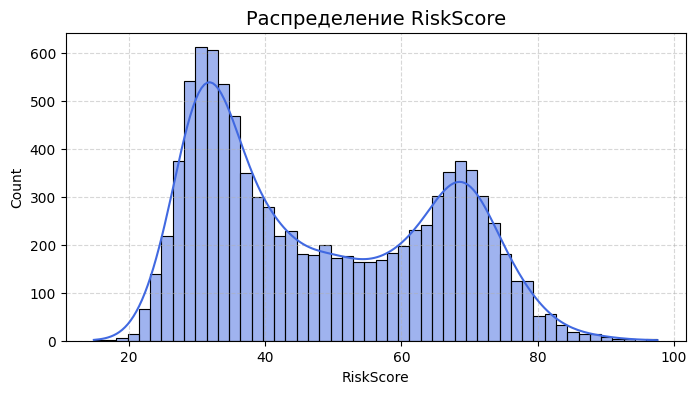

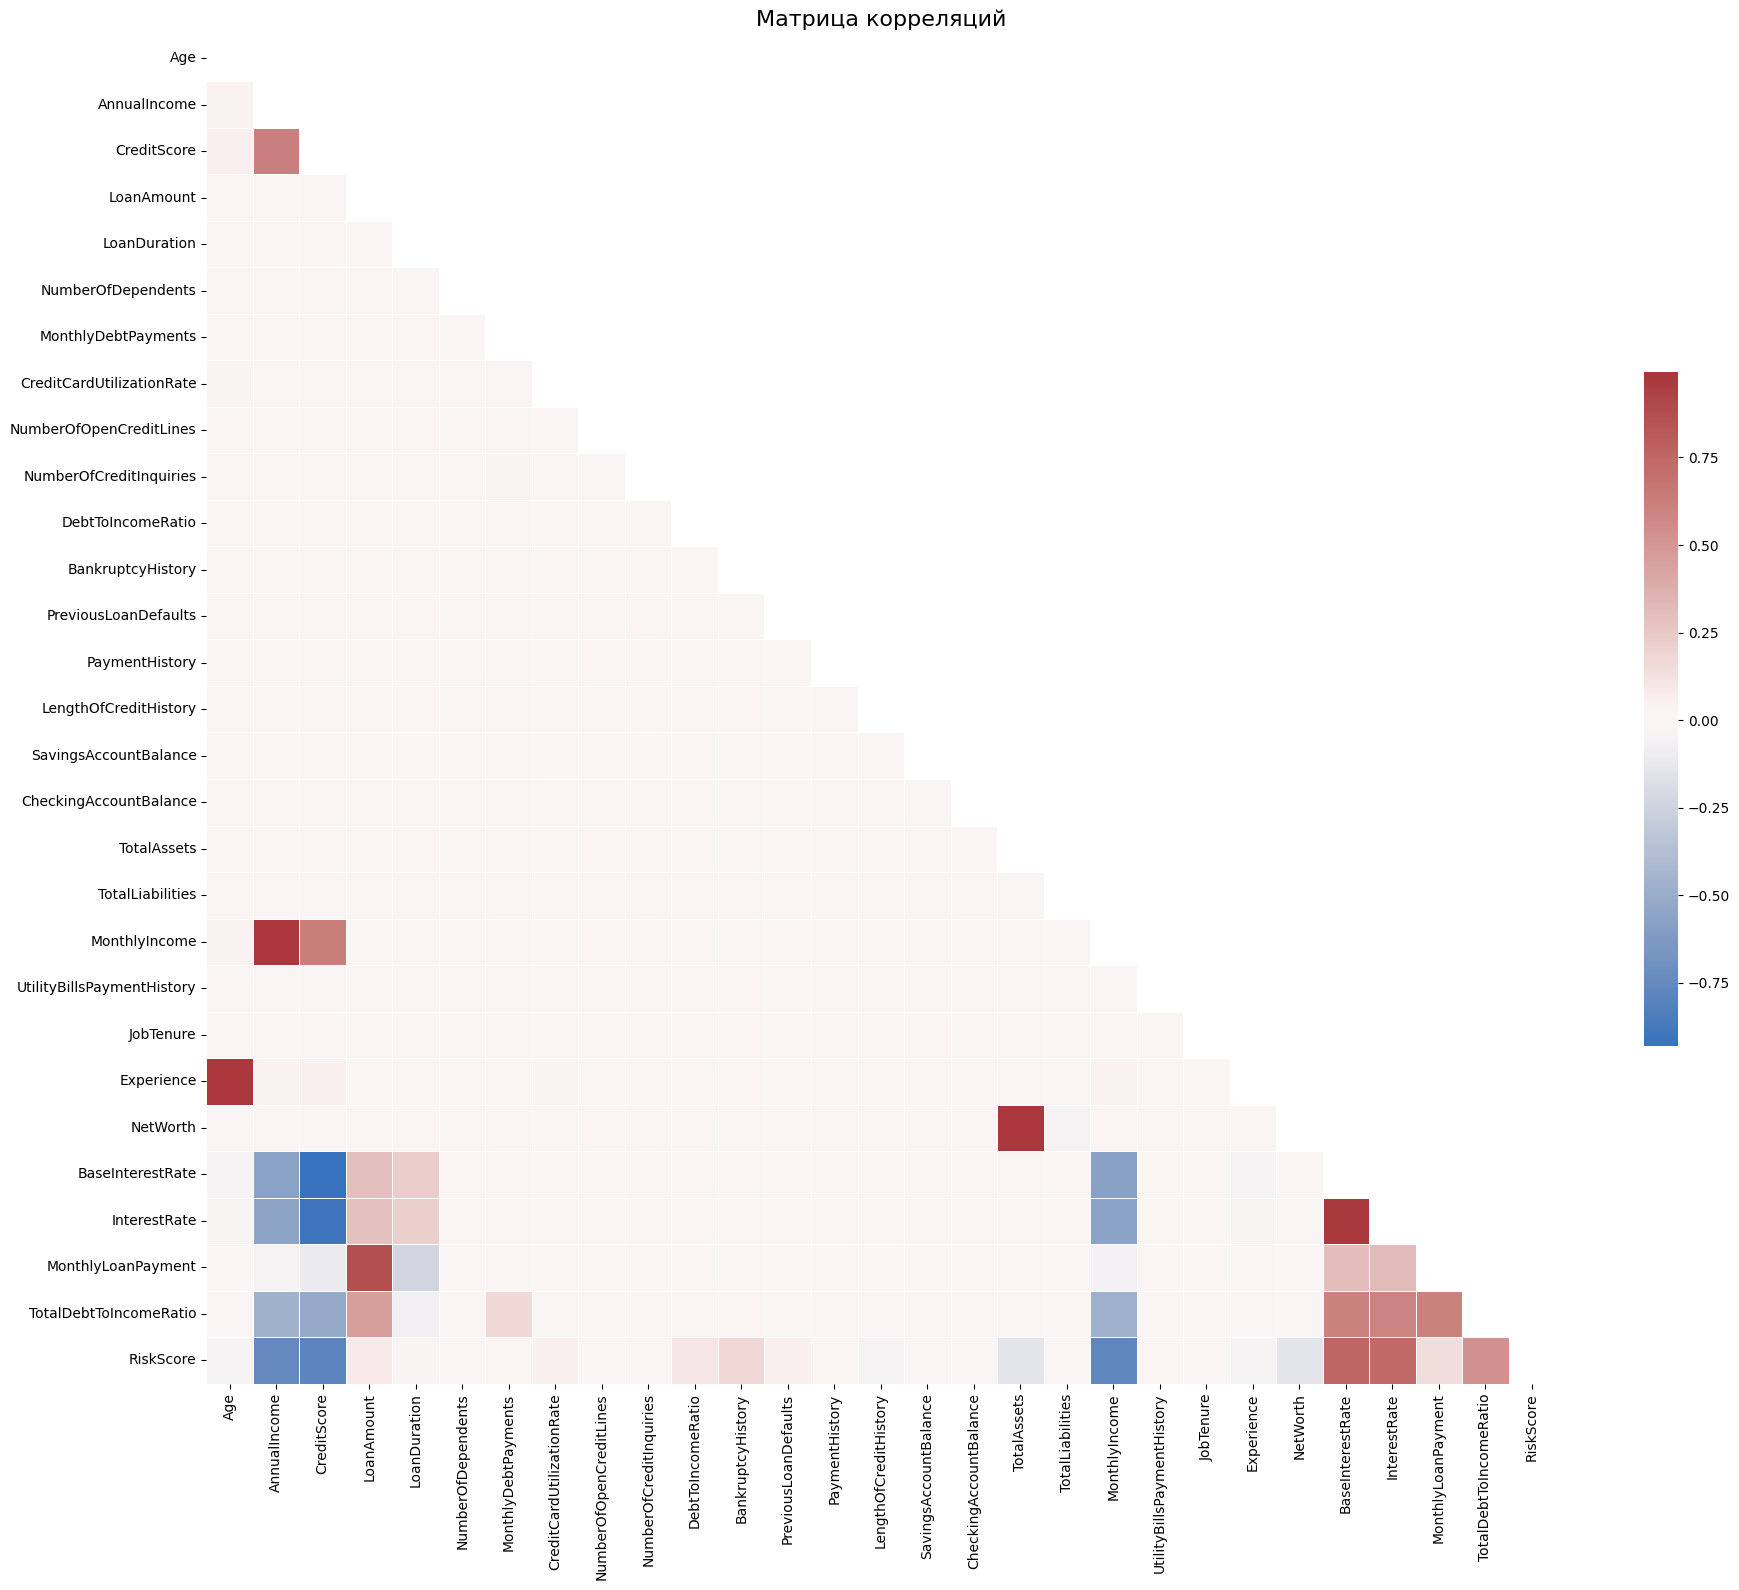


📈 Топ-12 признаков по модулю корреляции с RiskScore:
 1. CreditScore               | corr = -0.785 (↓)
 2. MonthlyIncome             | corr = -0.771 (↓)
 3. BaseInterestRate          | corr =  0.759 (↑)
 4. AnnualIncome              | corr = -0.758 (↓)
 5. InterestRate              | corr =  0.743 (↑)
 6. TotalDebtToIncomeRatio    | corr =  0.532 (↑)
 7. BankruptcyHistory         | corr =  0.178 (↑)
 8. MonthlyLoanPayment        | corr =  0.151 (↑)
 9. TotalAssets               | corr = -0.146 (↓)
10. NetWorth                  | corr = -0.145 (↓)
11. DebtToIncomeRatio         | corr =  0.111 (↑)
12. LoanAmount                | corr =  0.085 (↑)

🔍 Визуализация зависимости RiskScore от топ-12 признаков...


c:\Users\Nikita\Desktop\Новая папка\.venv\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\Nikita\Desktop\Новая папка\.venv\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\Nikita\Desktop\Новая папка\.venv\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\Nikita\Desktop\Новая папка\.venv\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


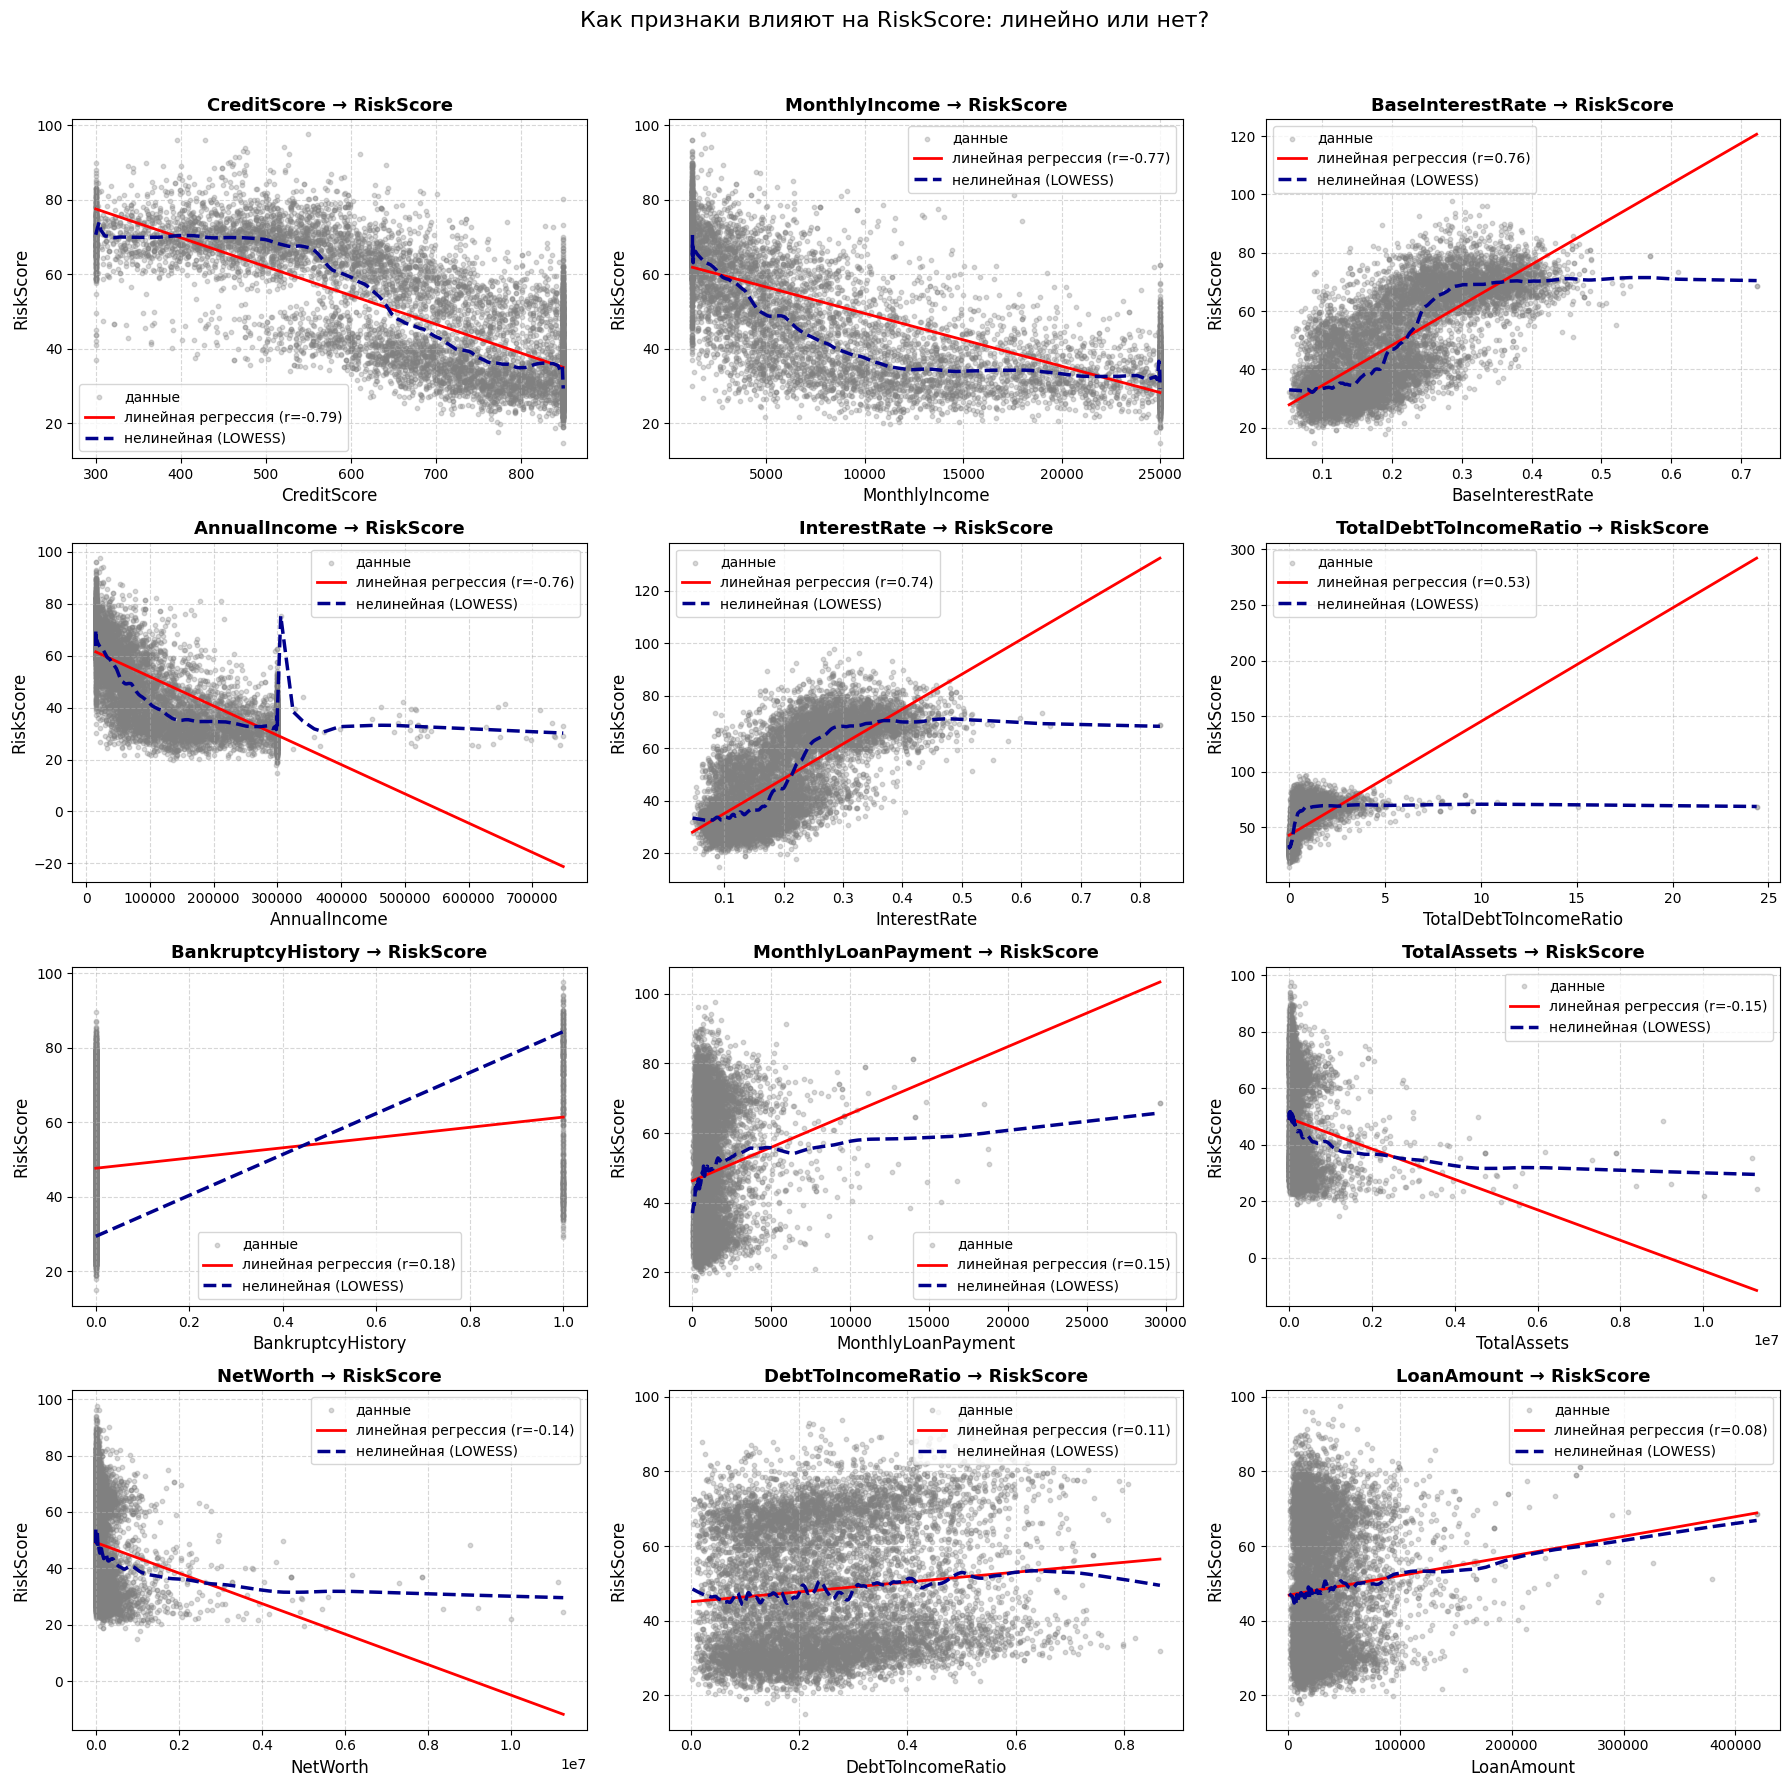


💡 Интерпретация:
- Если красная линия близка к синей пунктирной — зависимость ~линейная.
- Если синяя кривая изгибается (S-образно, U-образно и т.п.) — есть нелинейность.
- Если кривая 'выравнивается' на краях — эффект насыщения (плато).
- Если кривая резко меняет наклон — возможен порог/точка перегиба.
- Выбросы: точки далеко от облака основных данных.


In [183]:
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

target_col = 'RiskScore'
# Загружаем датасет
train_df = pd.read_csv('data/train.csv').dropna()
train_df = train_df[train_df['RiskScore'].between(-100, 200)]
train_df = train_df[train_df[target_col].abs() <= 100].reset_index(drop=True).dropna(subset=[target_col])


test_df = pd.read_csv('data/test.csv')

id_col = 'ID'

# Разведочный анализ
do_eda(train_df, target_col)

### Итоговое решение часть 2: все остальное

In [206]:
# Группируем данные для обучения
train_x = train_df.drop(columns=[target_col])
train_y = train_df[target_col]
test_x = test_df.drop(columns=[id_col])
test_ids = test_df[id_col]

cv = MyCrossValidator(method=CV_METHOD_KFOLD)

print('')
gd_p = 1.5 #float(input('Введите значение p для градиентного спуска с регуляризацией Lp'))
sgd_p = 1.5 # float(input('Введите значение p для стохастического градиентного спуска с регуляризацией Lp'))

print('Сравнение методов:')
verify_name = 'sklearn (проверка)'
best_score = float('inf')
best_model = None
for scale_name, scaler in [('zscore', MyFeatureScaler(method=SCALE_METHOD_ZSCORE)),
                           ('minmax', MyFeatureScaler(method=SCALE_METHOD_MINMAX)), ]:
    for name, linear_regression in [('аналитический', MyLinearRegression(method=LR_METHOD_ANALYTICAL)),
                                    ('аналитический L2', MyLinearRegression(method=LR_METHOD_ANALYTICAL, regularization=LR_REGULARIZATION_L2)),
                                    ('градиентный спуск', MyLinearRegression(method=LR_METHOD_GD)),
                                    ('градиентный спуск L1', MyLinearRegression(method=LR_METHOD_GD, regularization=LR_REGULARIZATION_L1)),
                                    ('градиентный спуск L2', MyLinearRegression(method=LR_METHOD_GD, regularization=LR_REGULARIZATION_L2)),
                                    ('градиентный спуск L1 + L2', MyLinearRegression(method=LR_METHOD_GD, regularization=LR_REGULARIZATION_L1L2)),
                                    ('градиентный спуск Lp', MyLinearRegression(method=LR_METHOD_GD, regularization=LR_REGULARIZATION_LP, p=gd_p)),
                                    ('стохастический градиентный спуск', MyLinearRegression(method=LR_METHOD_SGD)),
                                    ('стохастический градиентный спуск L1', MyLinearRegression(method=LR_METHOD_SGD, regularization=LR_REGULARIZATION_L1)),
                                    ('стохастический градиентный спуск L2', MyLinearRegression(method=LR_METHOD_SGD, regularization=LR_REGULARIZATION_L2)),
                                    ('стохастический градиентный спуск L1 + L2', MyLinearRegression(method=LR_METHOD_SGD, regularization=LR_REGULARIZATION_L1L2)),
                                    ('стохастический градиентный спуск Lp', MyLinearRegression(method=LR_METHOD_SGD, regularization=LR_REGULARIZATION_LP, p=sgd_p)),
                                    (verify_name, LinearRegression())]:
        p = MyPipeline(MyMissingValueImputer(), 
                    MyCategoricalEncoder(),
                    MyFeatureEngineer(),
                    scaler,
                    SelectPercentile(score_func=f_regression, percentile=70),
                    linear_regression)
        scores = []
        for idx_train, idx_test in cv.split(train_x):
            x_cv_train = train_x.iloc[idx_train].copy(deep=True)
            x_cv_test = train_x.iloc[idx_test].copy(deep=True)

            y_cv_train = train_y.iloc[idx_train].copy(deep=True)
            y_cv_test = train_y.iloc[idx_test].copy(deep=True)

            p.fit(x_cv_train, y_cv_train)

            y_perdicted = p.predict(x_cv_test)
            scores.append(MyMetrics.mse(y_cv_test, y_perdicted))
        
        mean = np.mean(scores)
        std = np.std(scores)

        if name != verify_name and mean < best_score:
            best_score = mean
            best_model = (f'{scale_name} + {name}', p)

        print(f'[CV MSE] {scale_name} + {name}: срзнач={mean} стдев={std}')

print(f'Лучшая метод по итогам кросс-валидации: {best_model[0]} со срзнач={best_score}')
print('')

p = best_model[1]
p.fit(train_x, train_y)
y_perdicted = p.predict(test_x)
y_perdicted = np.clip(y_perdicted, 0.0, 100.0)
submission = pd.DataFrame({ id_col: test_ids, target_col: y_perdicted })
out_path = 'submission.csv'
print(f'Сохраняем резултат в `{out_path}`...')
submission.to_csv(out_path, index=False)
print('Результат сохранен.')

print('')
print('Метрики и сравнение со sklearn:')
x_tr, x_ver, y_tr, y_ver = train_test_split(train_x, train_y)
p.fit(x_tr, y_tr)
y_pr = p.predict(x_ver)
print(f'MSE: моямодель={MyMetrics.mse(y_ver, y_pr)} sklearn={mean_squared_error(y_ver, y_pr)}')
print(f'MAE: моямодель={MyMetrics.mae(y_ver, y_pr)} sklearn={mean_absolute_error(y_ver, y_pr)}')
print(f'R2: моямодель={MyMetrics.r2(y_ver, y_pr)} sklearn={r2_score(y_ver, y_pr)}')
print(f'MAPE: моямодель={MyMetrics.mape(y_ver, y_pr)} sklearn={mean_absolute_percentage_error(y_ver, y_pr)}')


Сравнение методов:
[CV MSE] zscore + аналитический: срзнач=29.790835239116518 стдев=1.3438538545591614
[CV MSE] zscore + аналитический L2: срзнач=29.692041838137165 стдев=1.02140681349068
[CV MSE] zscore + градиентный спуск: срзнач=30.554013030466443 стдев=1.174634008843766


KeyboardInterrupt: 